# Facial Emotion Recognition Experiments

In this notebook, we will conduct experiments to train models on facial emotion recognition data. The dataset used here is a [FER-2013](https://www.kaggle.com/datasets/msambare/fer2013), which is a challenging due to its imbalance and small image size (48x38 pixels). The goal of these experiments is to identify which pre-trained model performs best for this task.

In this notebok, we will `Fine-tuning` the entire network of all the models one by one, because we have have a decent-sized dataset and want the model to adapt well to this specific problem. We will explore several models, including:
* **CNN-based models** like `resnet18`, `vgg16` and `densenet121`
* **Vision Transformers (ViT) model** such as `vit_b_16`
* **CLIP model** `ViT-B/32`.

These models will be evaluated to determine the most effective approach for categorizing facial expressions into seven emotion categories.

At the end of the experiments, we will compare and visualize the accuracy of each model on the test data as well as their respective training times.
* For training, NVIDA GeForce GTX 1070 Ti is used.
* Finally, we will compare the performance of all models, their accuracy on test dataset and training time.

## Imports and Setup

First, let's import the necessary libraries and set up the environment.


In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import clip

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

**Device agnostic Code**

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1070 Ti


In [4]:
!nvidia-smi

Wed Oct 16 19:22:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1070 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
|  0%   37C    P8             10W /  180W |       0MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Dataset Overview

* [FER-2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset is used, which is of **63** MB.
* The dataset consists of 48x48 pixel grayscale images of faces, categorized into seven emotions. 
* The data is organized into training and testing sets with subfolders representing each emotion.

```bash
data
 |- train
    |- angry
    |- disgust
    |- fear
    |- happy
    |- neutral
    |- sad
    |- surprise
 |- test
    |- angry
    |- disgust
    |- fear
    |- happy
    |- neutral
    |- sad
    |- surprise
```

## Data Loading and Visualization

### Loading the Dataset
We'll use `ImageFolder` from `torchvision.datasets` to load the data. Since the images are grayscale, we'll convert them to RGB by duplicating the single channel to match the pretrained models' expected input.

In [5]:
data_dir = './data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

**Define transformations**

In [6]:
# Pretrained models expect images of size at least 224x224 and 3 channels
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # Using ImageNet means
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [7]:
full_train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])

**Split the train set into train and validation sets**  

Since we have no predefined validation set in our dataset. So we'll split train dataset into separate train and validation subsets. This allows us to monitor the model's performance during training.

1. **Split the Training Dataset**  
    * We'll split the original training dataset into a new training set and a validation set.  
    **Split Ratios**  
        - **Training Set Ratio**: ~69.9%  
        - **Validation Set Ratio**: ~10.0%  
        - **Test Set Ratio**: ~20.0%  
    * Dataset is split into approximately 70% training, 10% validation, and 20% test.

In [8]:
# Define the size for training and validation sets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

In [9]:
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [10]:
val_dataset.dataset.transform = data_transforms['val']

In [11]:
# Load the test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

**Create DataLoader**

In [12]:
batch_size = 64
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

In [13]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
class_names = full_train_dataset.classes
print(f"Classes: {class_names}")
print(f"Training samples: {dataset_sizes['train']}")
print(f"Validation samples: {dataset_sizes['val']}")
print(f"Testing samples: {dataset_sizes['test']}")

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Training samples: 22967
Validation samples: 5742
Testing samples: 7178


## Visualizing the Dataset


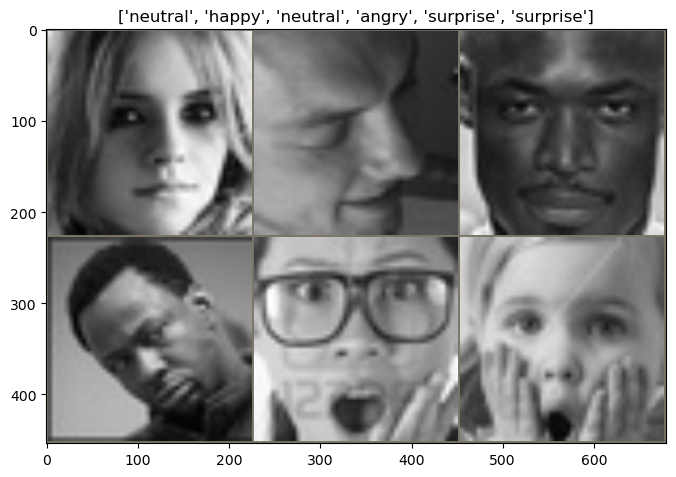

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert to HWC format
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a small batch of 6 training images
inputs, classes = next(iter(DataLoader(train_dataset, batch_size=6, shuffle=True)))
out = torchvision.utils.make_grid(inputs, nrow=3)

# Visualize images with corresponding labels
plt.figure(figsize=(8, 8))
imshow(out, title=[class_names[x] for x in classes])
plt.show()

## Utility Functions
Define utility functions for training, evaluating, plotting, and tracking training time.

In [15]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [16]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=15):
    since = time.time()

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase}'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track gradients only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, time_elapsed

In [17]:
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f'Test Accuracy: {acc:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    return acc

## Model Training and Evaluation
We'll experiment with three categories of models:

1. **Pretrained CNN-based Models** like `resnet18`, `vgg16` and `densenet121`
2. **Vision Transformer (ViT) Model** such as `vit_b_16`
3. **CLIP Models** `ViT-B/32`

For each category, we'll:

* Initialize the model
* Modify the final layer to match our number of classes
* Define loss and optimizer
* Train the model
* Evaluate and save results

### Pretrained CNN Models

#### Resnet18

In [18]:
# Initialize ResNet18
model_resnet = models.resnet18(pretrained=True)

In [19]:
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet = model_resnet.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-4)

**Train the model**

In [20]:
model_resnet, history_resnet, train_time_resnet18 = train_model(
    model_resnet, dataloaders, criterion, optimizer_resnet, num_epochs=5
)

Epoch 1/5
----------


train:   0%|          | 0/359 [00:00<?, ?it/s]

train: 100%|██████████| 359/359 [02:52<00:00,  2.09it/s]


Train Loss: 1.1594 Acc: 0.5624


val: 100%|██████████| 90/90 [00:40<00:00,  2.24it/s]


Val Loss: 1.0006 Acc: 0.6230

Epoch 2/5
----------


train: 100%|██████████| 359/359 [01:36<00:00,  3.72it/s]


Train Loss: 0.7757 Acc: 0.7146


val: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]


Val Loss: 0.9665 Acc: 0.6473

Epoch 3/5
----------


train: 100%|██████████| 359/359 [01:36<00:00,  3.72it/s]


Train Loss: 0.4430 Acc: 0.8494


val: 100%|██████████| 90/90 [00:29<00:00,  3.10it/s]


Val Loss: 1.0493 Acc: 0.6435

Epoch 4/5
----------


train: 100%|██████████| 359/359 [01:36<00:00,  3.73it/s]


Train Loss: 0.1707 Acc: 0.9519


val: 100%|██████████| 90/90 [00:28<00:00,  3.13it/s]


Val Loss: 1.2586 Acc: 0.6365

Epoch 5/5
----------


train: 100%|██████████| 359/359 [01:36<00:00,  3.71it/s]


Train Loss: 0.0807 Acc: 0.9818


val: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]

Val Loss: 1.3595 Acc: 0.6482

Training complete in 11m 54s
Best Validation Acc: 0.6482


**Evaluate the model**

Evaluating: 100%|██████████| 113/113 [00:38<00:00,  2.93it/s]


Test Accuracy: 0.6519


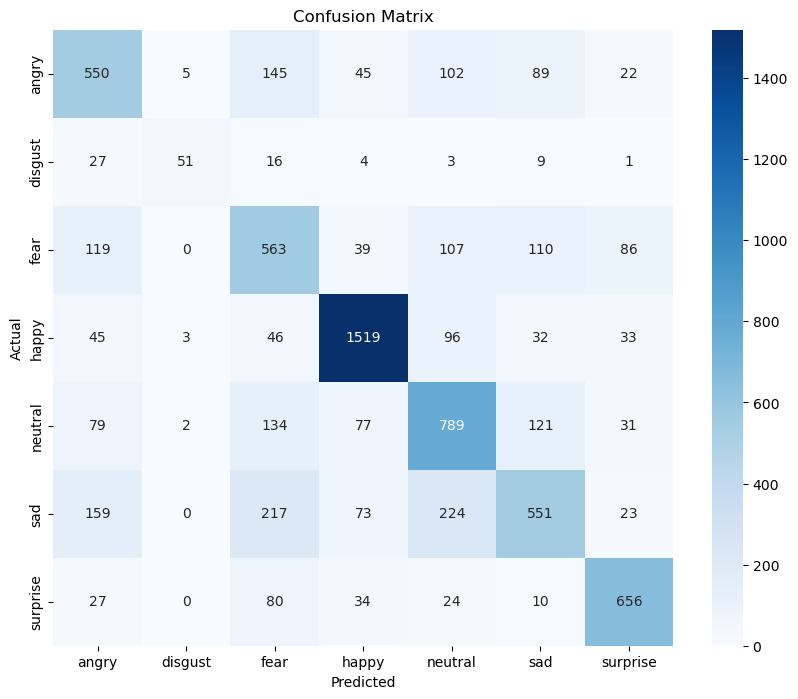

In [21]:
test_acc_resnet18 = evaluate_model(model_resnet, dataloaders['test'], class_names)

**Save the model**

In [22]:
torch.save(model_resnet.state_dict(), './models/resnet18_fer.pth')

**Plot learning curves**

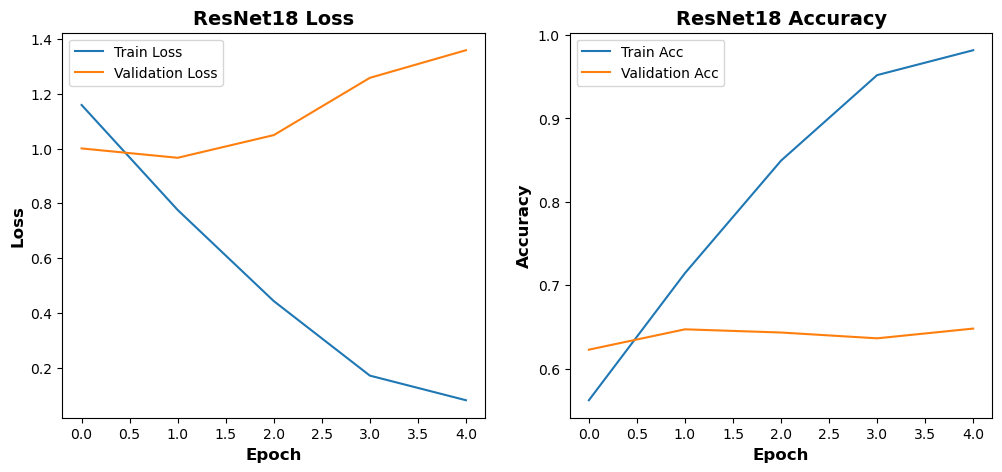

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_resnet['train_loss'], label='Train Loss')
plt.plot(history_resnet['val_loss'], label='Validation Loss')
plt.title('ResNet18 Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_resnet['train_acc'], label='Train Acc')
plt.plot(history_resnet['val_acc'], label='Validation Acc')
plt.title('ResNet18 Accuracy', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()

plt.show()

#### VGG16

In [18]:
model_resnet, history_resnet, train_time_resnet18 = train_model(
    model_resnet, dataloaders, criterion, optimizer_resnet, num_epochs=5
)

In [19]:
num_ftrs = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model_vgg = model_vgg.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_vgg = torch.optim.Adam(model_vgg.parameters(), lr=1e-4)

**Train the model**

In [20]:
model_vgg, history_vgg, train_time_vgg16 = train_model(
    model_vgg, dataloaders, criterion, optimizer_vgg, num_epochs=5
)

Epoch 1/5
----------


train: 100%|██████████| 359/359 [44:33<00:00,  7.45s/it]


Train Loss: 1.2785 Acc: 0.5062


val: 100%|██████████| 90/90 [01:32<00:00,  1.03s/it]


Val Loss: 1.0228 Acc: 0.6108

Epoch 2/5
----------


train: 100%|██████████| 359/359 [43:55<00:00,  7.34s/it]


Train Loss: 0.9716 Acc: 0.6384


val: 100%|██████████| 90/90 [00:46<00:00,  1.93it/s]


Val Loss: 0.9699 Acc: 0.6362

Epoch 3/5
----------


train: 100%|██████████| 359/359 [43:20<00:00,  7.24s/it]


Train Loss: 0.7694 Acc: 0.7148


val: 100%|██████████| 90/90 [00:45<00:00,  1.99it/s]


Val Loss: 0.9381 Acc: 0.6573

Epoch 4/5
----------


train: 100%|██████████| 359/359 [41:40<00:00,  6.97s/it]


Train Loss: 0.5449 Acc: 0.8015


val: 100%|██████████| 90/90 [00:45<00:00,  2.00it/s]


Val Loss: 1.0173 Acc: 0.6646

Epoch 5/5
----------


train: 100%|██████████| 359/359 [41:38<00:00,  6.96s/it]


Train Loss: 0.3421 Acc: 0.8774


val: 100%|██████████| 90/90 [00:54<00:00,  1.65it/s]

Val Loss: 1.3057 Acc: 0.6668

Training complete in 219m 54s
Best Validation Acc: 0.6668


**Evaluate the model**

Evaluating: 100%|██████████| 113/113 [01:03<00:00,  1.79it/s]


Test Accuracy: 0.6521


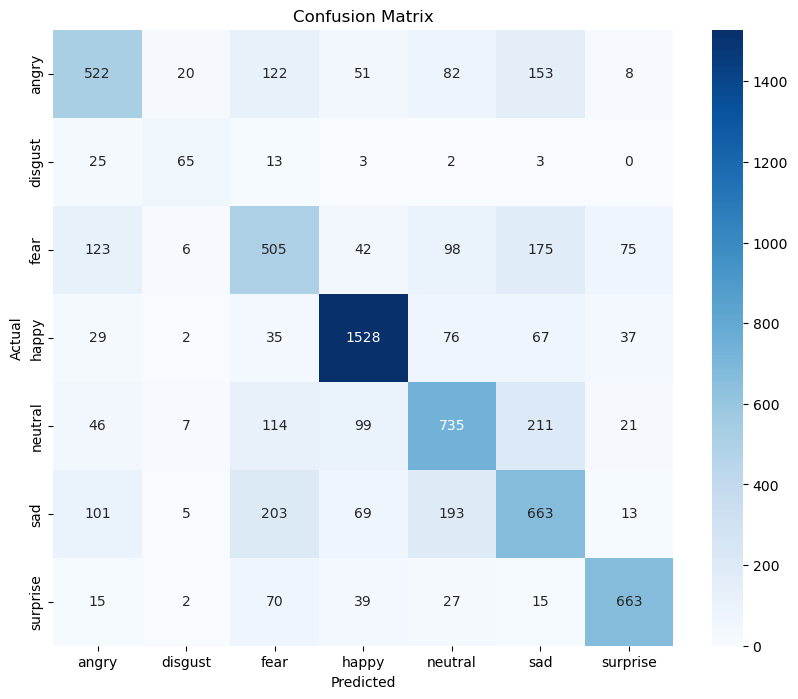

In [21]:
test_acc_vgg16 = evaluate_model(model_vgg, dataloaders['test'], class_names)

**Save the model**

In [22]:
torch.save(model_vgg.state_dict(), './models/vgg16_fer.pth')

**Plot learning curves**

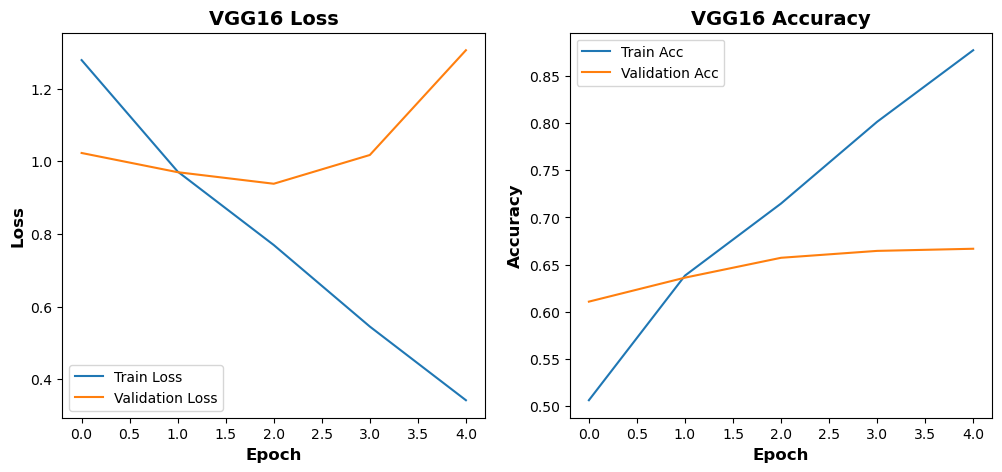

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vgg['train_loss'], label='Train Loss')
plt.plot(history_vgg['val_loss'], label='Validation Loss')
plt.title('VGG16 Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_vgg['train_acc'], label='Train Acc')
plt.plot(history_vgg['val_acc'], label='Validation Acc')
plt.title('VGG16 Accuracy', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()

plt.show()

#### DenseNet121

In [24]:
# Initialize DenseNet121
model_densenet = models.densenet121(pretrained=True)

In [25]:
num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = nn.Linear(num_ftrs, len(class_names))
model_densenet = model_densenet.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_densenet = torch.optim.Adam(model_densenet.parameters(), lr=1e-4)

**Train the model**

In [26]:
model_densenet, history_densenet, train_time_densenet121 = train_model(
    model_densenet, dataloaders, criterion, optimizer_densenet, num_epochs=5
)

Epoch 1/5
----------


train: 100%|██████████| 359/359 [1:07:45<00:00, 11.32s/it]


Train Loss: 1.1964 Acc: 0.5493


val: 100%|██████████| 90/90 [00:38<00:00,  2.36it/s]


Val Loss: 0.9657 Acc: 0.6372

Epoch 2/5
----------


train: 100%|██████████| 359/359 [1:08:01<00:00, 11.37s/it]


Train Loss: 0.8416 Acc: 0.6923


val: 100%|██████████| 90/90 [00:49<00:00,  1.81it/s]


Val Loss: 0.9109 Acc: 0.6630

Epoch 3/5
----------


train: 100%|██████████| 359/359 [1:07:07<00:00, 11.22s/it]


Train Loss: 0.6130 Acc: 0.7844


val: 100%|██████████| 90/90 [00:51<00:00,  1.74it/s]


Val Loss: 0.9698 Acc: 0.6451

Epoch 4/5
----------


train: 100%|██████████| 359/359 [1:06:02<00:00, 11.04s/it]


Train Loss: 0.3925 Acc: 0.8678


val: 100%|██████████| 90/90 [00:49<00:00,  1.83it/s]


Val Loss: 1.0212 Acc: 0.6609

Epoch 5/5
----------


train: 100%|██████████| 359/359 [1:06:05<00:00, 11.05s/it]


Train Loss: 0.2270 Acc: 0.9269


val: 100%|██████████| 90/90 [00:50<00:00,  1.78it/s]

Val Loss: 1.1412 Acc: 0.6597

Training complete in 339m 3s
Best Validation Acc: 0.6630


**Evaluate the model**

Evaluating: 100%|██████████| 113/113 [00:45<00:00,  2.46it/s]


Test Accuracy: 0.6530


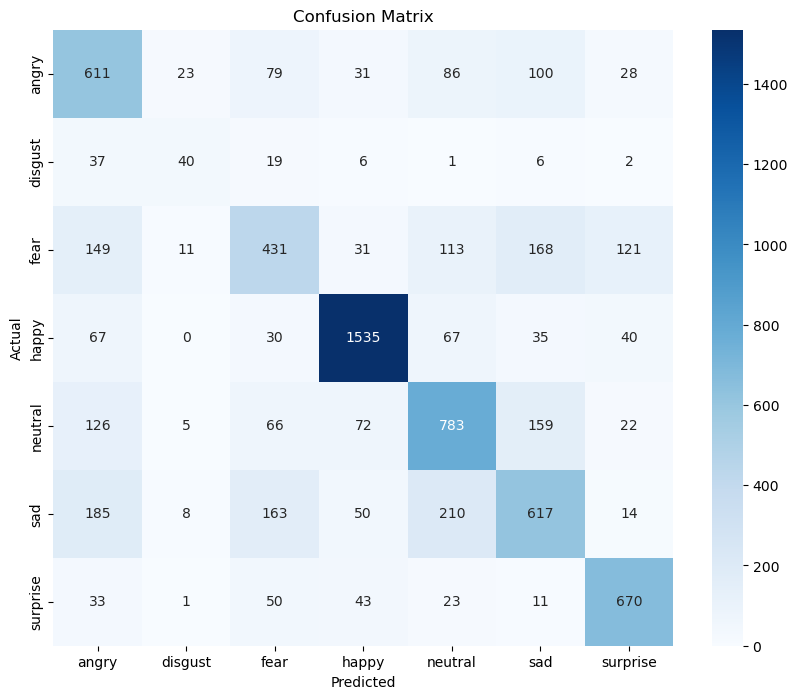

In [27]:
test_acc_densenet121 = evaluate_model(model_densenet, dataloaders['test'], class_names)

**Save the model**

In [28]:
torch.save(model_densenet.state_dict(), './models/densenet121_fer.pth')

**Plot the learning curves**

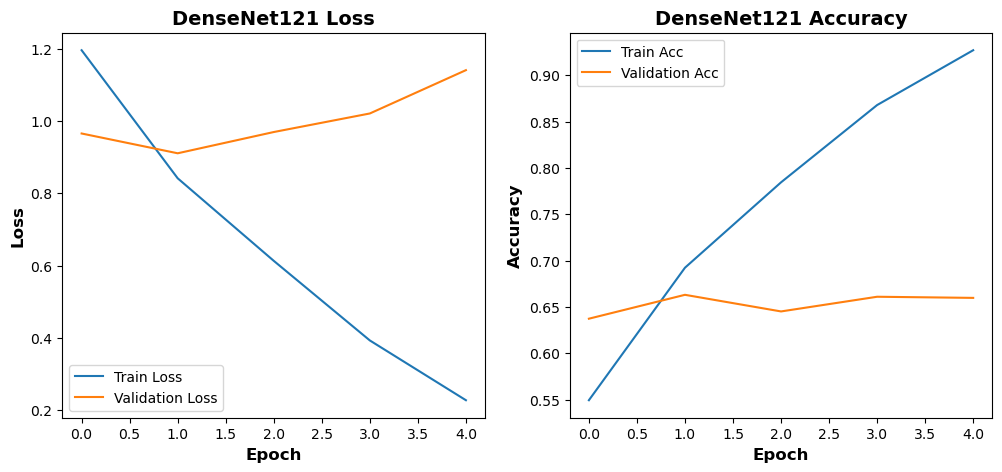

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_densenet['train_loss'], label='Train Loss')
plt.plot(history_densenet['val_loss'], label='Validation Loss')
plt.title('DenseNet121 Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_densenet['train_acc'], label='Train Acc')
plt.plot(history_densenet['val_acc'], label='Validation Acc')
plt.title('DenseNet121 Accuracy', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()

plt.show()

---

### Vision Transformer (ViT) Models
We'll use the `vit_b_16` model from `torchvision`.

In [30]:
# Initialize ViT
model_vit = models.vit_b_16(pretrained=True)

In [31]:
# Access the Linear layer inside the 'heads' Sequential
model_vit.heads[0] = nn.Linear(model_vit.heads[0].in_features, len(class_names))
model_vit = model_vit.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.Adam(model_vit.parameters(), lr=1e-4)

**Train the model**

In [32]:
model_vit, history_vit, train_time_vit = train_model(
    model_vit, dataloaders, criterion, optimizer_vit, num_epochs=5
)

Epoch 1/5
----------


train: 100%|██████████| 359/359 [1:26:36<00:00, 14.48s/it]


Train Loss: 1.1893 Acc: 0.5446


val: 100%|██████████| 90/90 [17:57<00:00, 11.97s/it]


Val Loss: 0.9874 Acc: 0.6170

Epoch 2/5
----------


train: 100%|██████████| 359/359 [1:17:35<00:00, 12.97s/it]


Train Loss: 0.9079 Acc: 0.6568


val: 100%|██████████| 90/90 [15:18<00:00, 10.21s/it]


Val Loss: 0.9392 Acc: 0.6524

Epoch 3/5
----------


train: 100%|██████████| 359/359 [1:34:59<00:00, 15.88s/it]


Train Loss: 0.7468 Acc: 0.7251


val: 100%|██████████| 90/90 [20:32<00:00, 13.70s/it]


Val Loss: 0.9764 Acc: 0.6322

Epoch 4/5
----------


train: 100%|██████████| 359/359 [1:35:03<00:00, 15.89s/it]


Train Loss: 0.5904 Acc: 0.7837


val: 100%|██████████| 90/90 [20:33<00:00, 13.70s/it]


Val Loss: 0.9585 Acc: 0.6552

Epoch 5/5
----------


train: 100%|██████████| 359/359 [1:24:29<00:00, 14.12s/it]


Train Loss: 0.4466 Acc: 0.8398


val: 100%|██████████| 90/90 [16:36<00:00, 11.07s/it]

Val Loss: 1.0071 Acc: 0.6623

Training complete in 529m 44s
Best Validation Acc: 0.6623


**Evalute the model**

Evaluating: 100%|██████████| 113/113 [27:47<00:00, 14.76s/it]


Test Accuracy: 0.6617


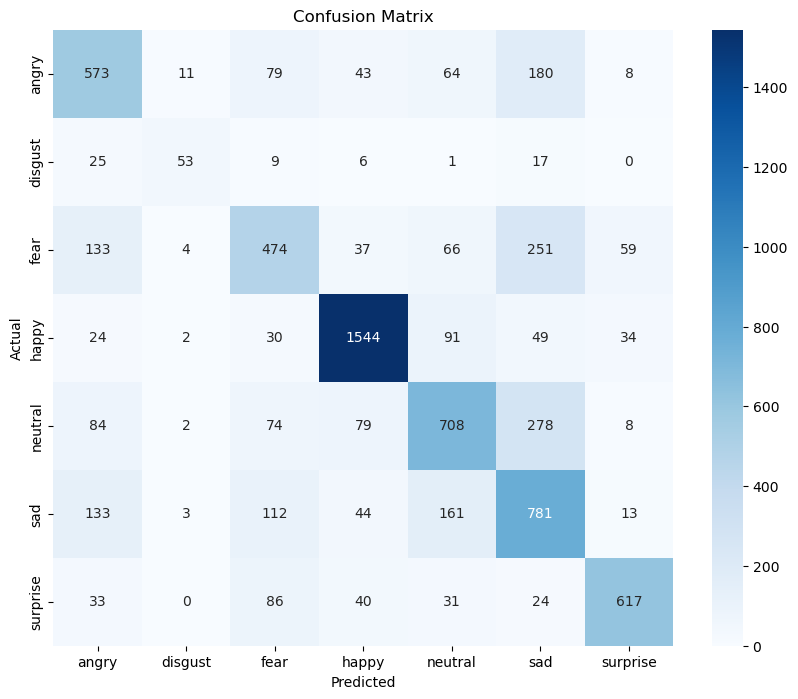

In [33]:
test_acc_vit = evaluate_model(model_vit, dataloaders['test'], class_names)

**Save the model**

In [34]:
torch.save(model_vit.state_dict(), './models/vit_b_16_fer.pth')

**Plot learning curves**

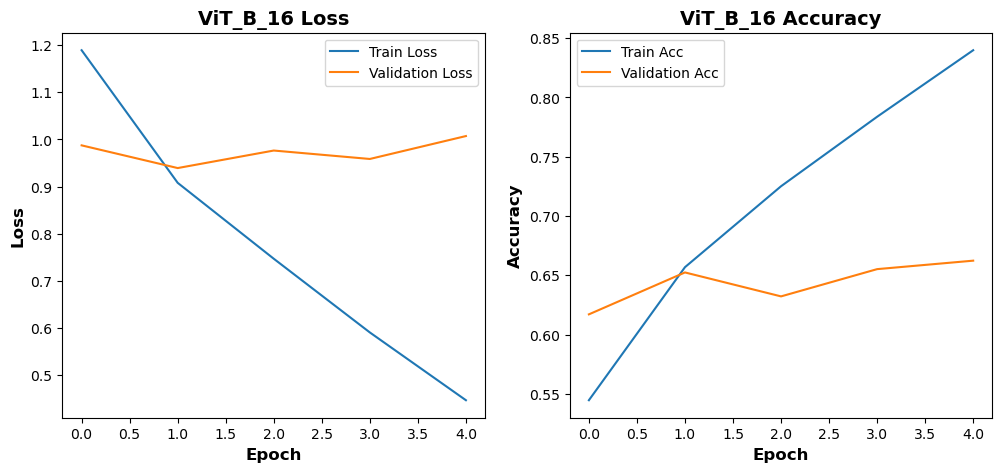

In [35]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vit['train_loss'], label='Train Loss')
plt.plot(history_vit['val_loss'], label='Validation Loss')
plt.title('ViT_B_16 Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_vit['train_acc'], label='Train Acc')
plt.plot(history_vit['val_acc'], label='Validation Acc')
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()
plt.title('ViT_B_16 Accuracy', fontweight='bold', fontsize=14)

plt.show()

---

### CLIP Models
We'll use OpenAI's CLIP model via `openai/clip` package. Note that CLIP is primarily designed for image-text tasks, but we can adapt it for classification.

In [36]:
# Install CLIP
# !pip install git+https://github.com/openai/CLIP.git

In [37]:
import clip

# Load CLIP model
model_clip, preprocess = clip.load("ViT-B/32", device=device)

In [38]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CLIPClassifier, self).__init__()
        self.clip_model = clip_model
        self.fc = nn.Linear(clip_model.visual.output_dim, num_classes)

    def forward(self, x):
        # Get image features from CLIP
        with torch.no_grad():
            image_features = self.clip_model.encode_image(x)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # Convert to float32 if it's in half precision
        if image_features.dtype == torch.float16:
            image_features = image_features.float()

        # Pass through classification head
        out = self.fc(image_features)
        return out

**Initialize CLIP-based classifier**

In [39]:
model_clip_classifier = CLIPClassifier(model_clip, len(class_names))
model_clip_classifier = model_clip_classifier.to(device)

In [40]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_clip = torch.optim.Adam(model_clip_classifier.fc.parameters(), lr=1e-4)

**Train the model**

In [41]:
model_clip_classifier, history_clip, train_time_clip = train_model(
    model_clip_classifier, dataloaders, criterion, optimizer_clip, num_epochs=5
)

Epoch 1/5
----------


train: 100%|██████████| 359/359 [13:46<00:00,  2.30s/it]


Train Loss: 1.8996 Acc: 0.2682


val: 100%|██████████| 90/90 [03:48<00:00,  2.54s/it]


Val Loss: 1.8559 Acc: 0.2746

Epoch 2/5
----------


train: 100%|██████████| 359/359 [22:16<00:00,  3.72s/it]


Train Loss: 1.8207 Acc: 0.2712


val: 100%|██████████| 90/90 [05:49<00:00,  3.88s/it]


Val Loss: 1.7892 Acc: 0.2732

Epoch 3/5
----------


train: 100%|██████████| 359/359 [22:23<00:00,  3.74s/it]


Train Loss: 1.7623 Acc: 0.2820


val: 100%|██████████| 90/90 [05:48<00:00,  3.87s/it]


Val Loss: 1.7370 Acc: 0.2884

Epoch 4/5
----------


train: 100%|██████████| 359/359 [19:29<00:00,  3.26s/it]


Train Loss: 1.7153 Acc: 0.3031


val: 100%|██████████| 90/90 [04:42<00:00,  3.14s/it]


Val Loss: 1.6935 Acc: 0.3210

Epoch 5/5
----------


train: 100%|██████████| 359/359 [14:09<00:00,  2.37s/it]


Train Loss: 1.6754 Acc: 0.3385


val: 100%|██████████| 90/90 [03:49<00:00,  2.55s/it]

Val Loss: 1.6555 Acc: 0.3622

Training complete in 116m 5s
Best Validation Acc: 0.3622


**Evaluate the model**

Evaluating: 100%|██████████| 113/113 [07:14<00:00,  3.85s/it]


Test Accuracy: 0.3498


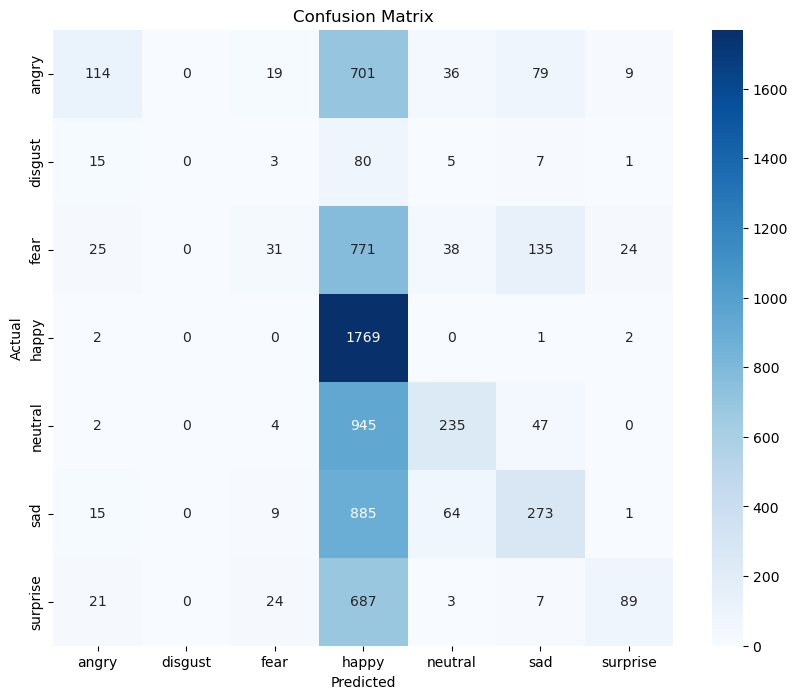

In [42]:
test_acc_clip = evaluate_model(model_clip_classifier, dataloaders['test'], class_names)

In [43]:
# Save the model
torch.save(model_clip_classifier.state_dict(), './models/clip_fer.pth')


**Plot learning curves**

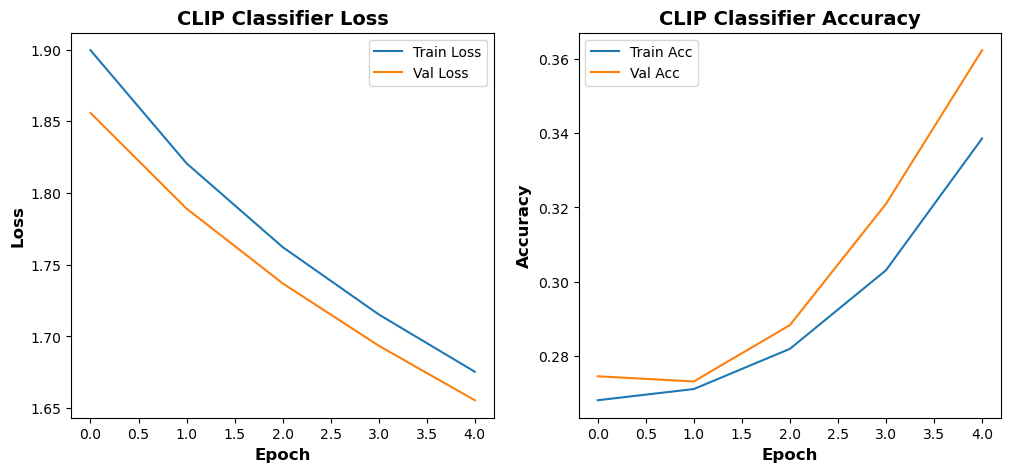

In [44]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_clip['train_loss'], label='Train Loss')
plt.plot(history_clip['val_loss'], label='Val Loss')
plt.title('CLIP Classifier Loss', fontweight='bold', fontsize=14)
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Loss', fontweight='bold', fontsize=12)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_clip['train_acc'], label='Train Acc')
plt.plot(history_clip['val_acc'], label='Val Acc')
plt.xlabel('Epoch', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.legend()
plt.title('CLIP Classifier Accuracy', fontweight='bold', fontsize=14)

plt.show()


---

**Models Comparison**

In [46]:
results = {
    'Model': ['ResNet18', 'VGG16', 'DesnseNet121', 'ViT (vit_b_16)', 'CLIP (ViT-B/32)'],
    'Accuracy': [
        test_acc_resnet18,
        test_acc_vgg16,
        test_acc_densenet121,
        test_acc_vit,
        test_acc_clip
    ],
    'Training Time': [
        train_time_resnet18,
        train_time_vgg16,
        train_time_densenet121,
        train_time_vit,
        train_time_clip
    ]
}

In [47]:
import pandas as pd
# Create DataFrame
df = pd.DataFrame(results)
print(df.to_string(index=False))

          Model  Accuracy  Training Time
       ResNet18  0.651900     714.000000
          VGG16  0.652100   13194.000000
   DesnseNet121  0.653000   20343.000000
 ViT (vit_b_16)  0.661744   31783.746233
CLIP (ViT-B/32)  0.349819    6965.253006


**Bar chart for accuracy comparison**

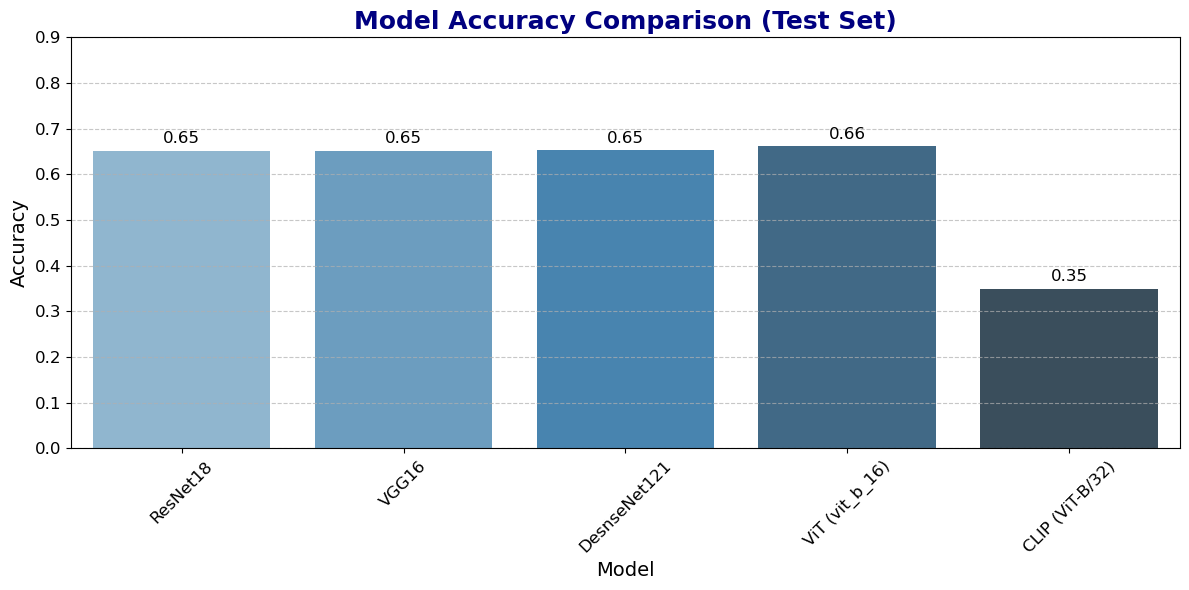

In [48]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Model', y='Accuracy', palette='Blues_d')

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels on top of each bar
for index, value in enumerate(df['Accuracy']):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=12)

plt.title('Model Accuracy Comparison (Test Set)', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.0, 0.9)
plt.tight_layout()
plt.show()

**Line Plot for Models Accuracy Comparison**  
Interactive Line Plot for Models Accuracy Comparison

In [49]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()

# Add line and markers
fig.add_trace(go.Scatter(x=df['Model'], y=df['Accuracy'],
                         mode='lines+markers',
                         line=dict(width=2, color='royalblue'),
                         marker=dict(size=10, color='darkblue', line=dict(width=2, color='black')),
                         name='Accuracy'))

# Fill area under the line
fig.add_trace(go.Scatter(x=df['Model'], y=df['Accuracy'],
                         mode='lines',
                         fill='tozeroy',  # Fill to zero
                         fillcolor='rgba(173, 216, 230, 0.5)',  # Light blue fill
                         line=dict(color='rgba(255, 255, 255, 0)'),  # Invisible line
                         showlegend=False))

fig.update_layout(title='Model Accuracy Comparison',
                  title_font=dict(size=20, family='Arial, sans-serif', color='navy'),
                  xaxis_title='Model',
                  yaxis_title='Accuracy',
                  yaxis=dict(range=[0.0, 0.9]),
                  xaxis_tickangle=-45,
                  template='plotly_white',
                  font=dict(size=14))

fig.show()

**Bar plot for training time**

In [50]:
# Convert seconds to minutes:seconds format
df['Training Time (m:s)'] = df['Training Time'].apply(lambda x: f"{int(x // 60)}:{int(x % 60):02d}")

# Create the interactive bar chart
fig = go.Figure(data=[go.Bar(
    x=df['Model'],
    y=df['Training Time'],
    text=df['Training Time (m:s)'],
    textposition='auto',
    hoverinfo='text',
    marker_color=px.colors.qualitative.Plotly
)])

fig.update_layout(
    title='Model Training Time Comparison',
    xaxis_title='Model',
    yaxis_title='Training Time (seconds)',
    font=dict(size=14)
)
fig.show()

---